In [1]:
import copy
import numpy as np
import os
import verdict

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.patheffects as path_effects
import matplotlib.gridspec as gridspec
import matplotlib.transforms as transforms

In [3]:
import analysis_config

In [4]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.worldline_set as a_w_set
import linefinder.analyze_data.plot_worldlines as p_worldlines

In [5]:
import linefinder.utils.presentation_constants as p_constants
import linefinder.utils.file_management as file_management
import linefinder.config as linefinder_config

In [6]:
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.analyze_data.particle_data as particle_data
import galaxy_dive.utils.astro as astro_utils
import galaxy_dive.utils.utilities as utilities
import galaxy_dive.utils.executable_helpers as exec_helpers
import galaxy_dive.utils.data_operations as data_operations
import galaxy_dive.plot_data.qual_colormaps as qual_colormaps

# Load Data

In [7]:
do_calculation = False

In [8]:
snum, galdef = exec_helpers.choose_config_or_commandline(
    [ analysis_config.SNUM, analysis_config.GALDEF ]
)
print( 'Using snum {}, galdef {}'.format( snum, galdef ) )

Using snum 465, galdef 


In [9]:
tag_tail = '_CGM_snum{}'.format( snum )

In [10]:
ahf_index = 600

In [11]:
ind = ahf_index - snum

In [12]:
# Load the a helper for loading files easily
file_manager = file_management.FileManager( project='CGM_fate' )

In [13]:
defaults, variations = file_manager.get_linefinder_analysis_defaults_and_variations(
    tag_tail, 
    sim_names = analysis_config.SIM_NAMES,
    galdef = galdef,
)

In [14]:
w_set = a_w_set.WorldlineSet( defaults, variations )

## Get Processed Data

In [15]:
classification_list = copy.copy( p_constants.CLASSIFICATIONS_CGM_FATE )
classification_list.append( 'is_in_CGM' )
classification_list.append( 'is_in_CGM_not_sat' )

In [16]:
if do_calculation:
    
    data_keys = [ 'T', 'Z_asplund', 'M' ]
    
    # Prep the Data Structure
    data = {}
    for data_key in data_keys:
        data[data_key] = {}
        for classification in classification_list:
            data[data_key][classification] = {}

    # Get the data
    for sim_name in w_set.keys():

        print( sim_name )

        for classification in classification_list:

            w = w_set[sim_name].data_object

            w.mask_data( 'PType', data_value=0 )
            w.mask_data( 'is_in_CGM_not_sat', data_value=True )

            for data_key in data_keys:
                data[data_key][classification][sim_name] = w.get_selected_data(
                    data_key,
                    sl = (slice(None),ind),
                    classification = classification
                )

        w.clear_data()    

#### Halo Masses

In [17]:
if do_calculation:
    w_set.data_object.retrieve_halo_data()
    halo_masses = w_set.m_vir.inner_item( snum )

#### Save and load results

In [18]:
savefile = os.path.join(
    file_manager.project_parameters['output_data_dir'],
    'cgm_fates_temps_and_mets_snum{}.hdf5'.format( snum ),
)

In [19]:
if do_calculation:
    
    data = verdict.Dict( data )

    # Format results to save
    results_to_save = copy.deepcopy( verdict.Dict( data ) )
    results_to_save['m_vir'] = halo_masses

    results_to_save.to_hdf5(
        savefile, 
        condensed = False, 
        attributes = { 'redshift': w.redshift.values[ind] },
    )
    
    redshift = w.redshift.values[ind]

In [20]:
if not do_calculation:
    results_to_load, attributes = verdict.Dict.from_hdf5( savefile, unpack=False )
    
    halo_masses = results_to_load['m_vir']
    data = copy.deepcopy( results_to_load )
    del data['m_vir']
    
    redshift = attributes['redshift']
    

# Plotting

In [21]:
plot_classification_list = copy.deepcopy( classification_list )
plot_classification_list.remove( 'is_CGM_halo_transfer' )
plot_classification_list.remove( 'is_in_CGM' )
plot_classification_list.remove( 'is_in_CGM_not_sat' )
if snum == 172:
    plot_classification_list.remove( 'is_CGM_still' )

In [22]:
mass_bins = [ 'm12', 'm11', 'm10' ]

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


File saved at /home1/03057/zhafen/papers/CGM_fate/figures/temp_of_prox_fate_CGM_snum465.pdf


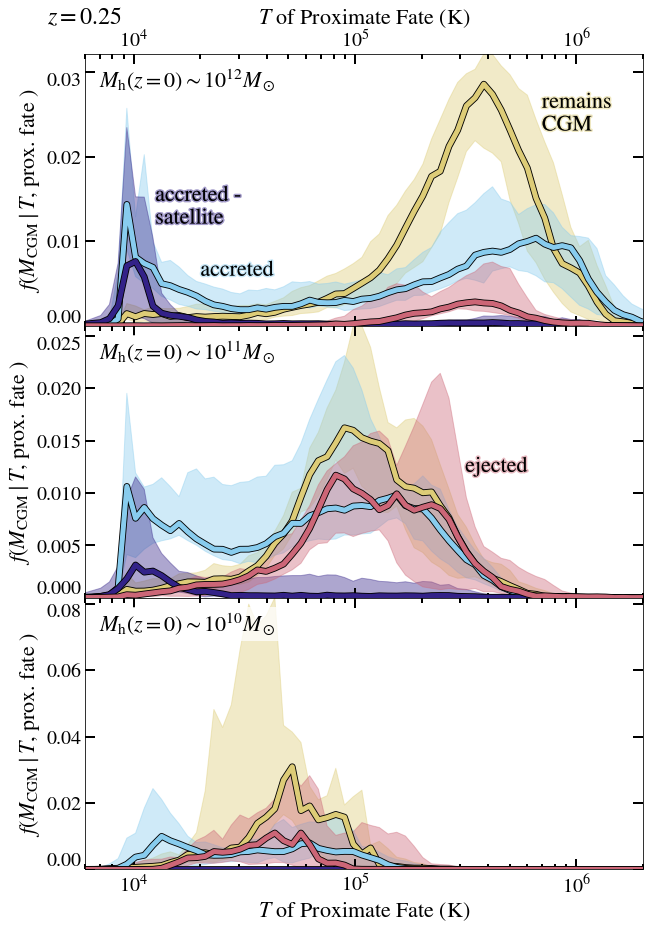

In [23]:
bins = np.logspace( 2., 7., 128 )

n_rows = len( mass_bins )

fig = plt.figure( figsize=(10,5*n_rows), facecolor='w' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( n_rows, 1, )
gs.update(wspace=0.025, hspace=0.0001)

norm_masses = data['M']['is_in_CGM'].sum()

for i, mass_bin in enumerate( mass_bins ):
    
    ax = plt.subplot( gs[i,0] )
    
    maxes = []

    for j, classification in enumerate( plot_classification_list ):
        
        if snum == 172 and not ax.is_first_row() and classification == 'is_CGM_accreted_to_satellite':
            continue

        sub_data = data['T'][classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]
        sub_masses = data['M'][classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]

        # Get the histograms out
        hists = verdict.Dict( {} )
        for sim_name in sub_data.keys():

            hists[sim_name], bins = np.histogram(
                sub_data[sim_name],
                bins = bins,
                weights = sub_masses[sim_name],
            )

            hists[sim_name] /= norm_masses[sim_name]

        # Plot actual lines
        x_arr = ( bins[:-1] + 0.5*( bins[1] - bins[0] ) )
        h_arr = hists.array()  
        line = ax.plot(
            x_arr,
            np.nanmedian( h_arr, axis=0 ),
            color = p_constants.CLASSIFICATION_COLORS_B[classification],
            linewidth = 5,
        )
        line[0].set_path_effects([
            path_effects.Stroke(
                linewidth=6.75, 
                foreground='k',
            ),
            path_effects.Normal(),
        ])
        upper_percentile = np.nanpercentile( h_arr, 84, axis=0 )
        ax.fill_between(
            x_arr,
            np.nanpercentile( h_arr, 16, axis=0 ),
            upper_percentile,
            color = p_constants.CLASSIFICATION_COLORS_B[classification],
            alpha = 0.4,
        )
        
        maxes.append( upper_percentile.max() )

    ax.set_xscale( 'log' )
    ax.set_xlim( 6e3, 2e6 )
    ax.set_ylim( 0, np.array( maxes ).max() )
    
    # Labels
    ax.set_xlabel( r'$T$ of Proximate Fate (K)', fontsize=22 )
    if ax.is_first_row():
        ax.xaxis.set_label_position( 'top' )
    ax.set_ylabel( r'$f(M_{\rm CGM} \mid T$, prox. fate $)$', fontsize=22, )
    
    # Bin labels
    bbox_props = dict( fc="w", alpha=0.75, lw=0 )
    xy = {
        465: ( 0.025, 0.95 ),
        172: ( 0.975, 0.95 ),
    }
    ha = {
        465: 'left',
        172: 'right',
    }
    ax.annotate(
        s = r'$M_{\rm h}(z=0) \sim 10^{' + mass_bin[1:] + r'} M_\odot$',
        xy = xy[snum],
        xycoords = 'axes fraction',
        horizontalalignment = ha[snum],
        verticalalignment = 'top',
        fontsize = 22,
        bbox = bbox_props,
    )

    # Hide some axis labels
    if not ax.is_last_row():
        ax.tick_params( labelbottom = False )
    if ax.is_first_row():
        ax.tick_params( labeltop = True )
        
    # Avoid overlapping ticks
    ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
    ax.get_yticklabels()[-2].set_verticalalignment( 'top' )

    # Plot label
    if ax.is_first_row():
        ax.annotate(
            s = r'$z=' + '{:.02g}'.format( redshift ) + '$',
            xy = ( 0.0, 1.0 ),
            xytext = ( 0., 25., ),
            xycoords = 'axes fraction',
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'bottom',
            fontsize = 24,
        )

    # Adjust tick parameters
    ax.tick_params( direction='in', which='both', top=True, right=True )
    
# Add labels
line_label_args = {
    465: {
        'is_CGM_accreted': {
            'xy': ( 2e4, 0.0065 ),
        },
        'is_CGM_accreted_to_satellite': {
            's': 'accreted -\nsatellite',
            'xy': (1.25e4, 0.014 ),
        },
        'is_CGM_ejected': {
            'xy': ( 3.15e5, 0.0125 ),
        },
        'is_CGM_still': {
            's': 'remains\nCGM',
            'xy': ( 7e5, 0.025 ),
        }
    },
    172: {
        'is_CGM_accreted': {
            'xy': ( 2.9e4, 0.019 ),
        },
        'is_CGM_ejected': {
            'xy': ( 5e5, 0.014 ),
        }
    },
}
axes = {
    465: {
        'is_CGM_accreted': 0,
        'is_CGM_accreted_to_satellite': 0,
        'is_CGM_ejected': 1,
        'is_CGM_still': 0,
    },
    172: {
        'is_CGM_accreted': 0,
        'is_CGM_ejected': 0,
    }
}
for key, item in line_label_args[snum].items():
    
    ax = plt.subplot( gs[axes[snum][key],0] )
    
    defaults = {
        's' : p_constants.CLASSIFICATION_LABELS[key],
        'fontsize' : 22,
        'color' : 'k',
        'va': 'center',
        'ha': 'left',
    }
    args = utilities.merge_two_dicts( item, defaults )

    text = ax.annotate( **args )

    text.set_path_effects([
        path_effects.Stroke(
            linewidth=3, 
            foreground=linefinder_config.COLORSCHEME[key],
            alpha = 0.45,
        ),
        path_effects.Normal(),
    ])

save_file = 'temp_of_prox_fate{}.pdf'.format( tag_tail )

plotting.save_fig(
    out_dir = file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
)

fig

File saved at /home1/03057/zhafen/papers/CGM_fate/figures/met_of_prox_fate_CGM_snum465.pdf


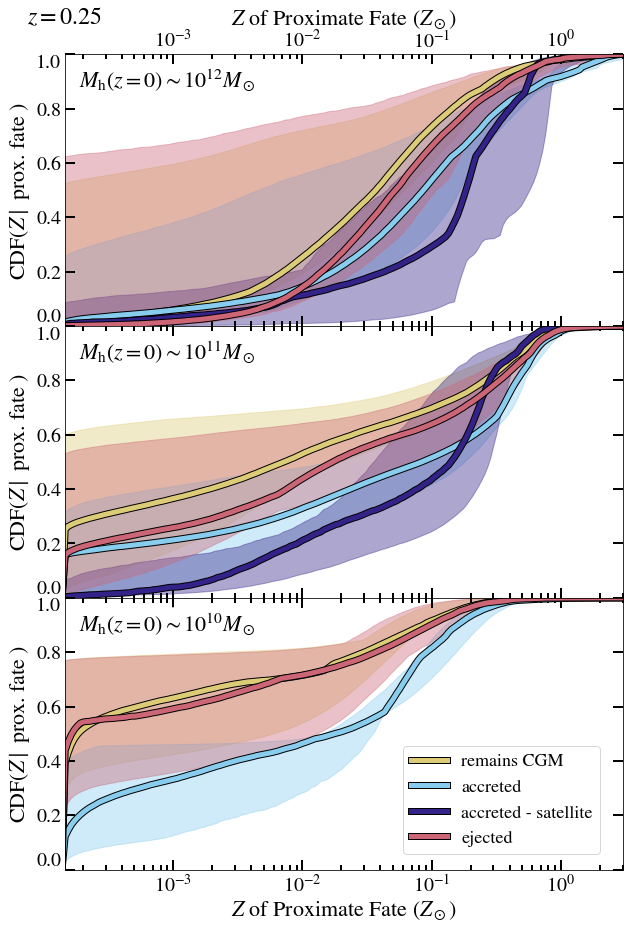

In [24]:
bins = np.linspace( -4, 2, 256 )


n_rows = len( mass_bins )

fig = plt.figure( figsize=(10,5*n_rows), facecolor='w' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( n_rows, 1, )
gs.update(wspace=0.025, hspace=0.0001)

norm_masses = data['M']['is_in_CGM'].sum()

for i, mass_bin in enumerate( mass_bins ):
    
    ax = plt.subplot( gs[i,0] )
    
    maxes = []

    for j, classification in enumerate( plot_classification_list ):
        
        if snum == 172 and not ax.is_first_row() and classification == 'is_CGM_accreted_to_satellite':
            continue

        sub_data = data['Z_asplund'][classification].split_by_dict( linefinder_config.MASS_BINS )[mass_bin]

        # Get the histograms out
        hists = verdict.Dict( {} )
        for sim_name in sub_data.keys():

            hists[sim_name], bins = np.histogram(
                np.log10( sub_data[sim_name] ),
                bins = bins,
                density = True,
            )

            hists[sim_name] = np.cumsum( hists[sim_name] ) * np.diff( bins )[0]

        # Plot actual lines
        x_arr = 10.**bins[:-1]
        h_arr = hists.array()  
        line = ax.plot(
            x_arr,
            np.nanmedian( h_arr, axis=0 ),
            color = p_constants.CLASSIFICATION_COLORS_B[classification],
            linewidth = 5,
            label = p_constants.CLASSIFICATION_LABELS[classification],
        )
        line[0].set_path_effects([
            path_effects.Stroke(
                linewidth=7, 
                foreground='k',
            ),
            path_effects.Normal(),
        ])
        upper_percentile = np.nanpercentile( h_arr, 84, axis=0 )
        ax.fill_between(
            x_arr,
            np.nanpercentile( h_arr, 16, axis=0 ),
            upper_percentile,
            color = p_constants.CLASSIFICATION_COLORS_B[classification],
            alpha = 0.4,
#             step = 'post',
        )
        
        maxes.append( upper_percentile.max() )

    ax.set_xscale( 'log' )
    ax.set_xlim( 1.45e-4, 3 )
    ax.set_ylim( 0, 1. )
    
    # Labels
    ax.set_xlabel( r'$Z$ of Proximate Fate $(Z_\odot)$', fontsize=22 )
    if ax.is_first_row():
        ax.xaxis.set_label_position( 'top' )
    ax.set_ylabel( r'CDF$(Z \mid$ prox. fate $)$', fontsize=22, )

    # Bin labels
    bbox_props = dict( fc="w", alpha=0.75, lw=0 )
    ax.annotate(
        s = r'$M_{\rm h}(z=0) \sim 10^{' + mass_bin[1:] + r'} M_\odot$',
        xy = ( 0.025, 0.95 ),
        xycoords = 'axes fraction',
        horizontalalignment = 'left',
        verticalalignment = 'top',
        fontsize = 22,
        bbox = bbox_props,
    )

    # Hide some axis labels
    if not ax.is_last_row():
        ax.tick_params( labelbottom = False )
    if ax.is_first_row():
        ax.tick_params( labeltop = True )
        
    # Avoid overlapping ticks
    ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
    ax.get_yticklabels()[-1].set_verticalalignment( 'top' )

    # Plot label
    if ax.is_first_row():
        ax.annotate(
            s = r'$z=' + '{:.02g}'.format( redshift ) + '$',
            xy = ( 0.0, 1.0 ),
            xytext = ( 0., 25., ),
            xycoords = 'axes fraction',
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'bottom',
            fontsize = 24,
        )

    # Adjust tick parameters
    ax.tick_params( direction='in', which='both', top=True, right=True )
    
    # Legend
    if ax.is_first_row():
        handles, labels = ax.get_legend_handles_labels()
        
    if ( snum == 465 and ax.is_last_row() ) or ( snum == 172 and ax.is_first_row() ):
        legend = ax.legend(
            handles,
            labels,
            prop = { 'size': 18 },
            loc = 'lower right',
            bbox_to_anchor = ( 0.975, 0.025),
            ncol = 1,
        )
        legend.set_zorder( 1000 )

save_file = 'met_of_prox_fate{}.pdf'.format( tag_tail )

plotting.save_fig(
    out_dir = file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
)

fig